# WordPic

## Importar

In [1]:
# %load basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Images/'

In [2]:
import os
os.listdir(liga[:-7] + 'Text/')

['IV.csv', 'poem.txt', 'VI.csv', 'V.csv']

In [3]:
##Veamos estructura del archivo (ej. para saber qué separador usar)
with open(liga[:-7] + 'Text/IV.csv','rb') as file:
    file = file.read()
    
file[:222]

b"character,dialogue\r\nTHREEPIO,Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!\r\nTHREEPIO,We're doomed!\r\nTHREEPIO,There'll be no escape for the Princess this time.\r\nTHRE"

In [4]:
df = pd.DataFrame()
for episodio in ['IV.csv', 'VI.csv', 'V.csv']:
    aux = pd.read_csv(liga[:-7] + 'Text/' +episodio)
    aux['Ep'] = episodio[:-4]
    df = df.append(aux)

df.rename(columns = {'dialogue':'Texto'}, inplace = True)
df.sample(7)

,character,Texto,Ep
640,LANDO,"We're on our way. Red Group, Gold Group, all f...",VI
733,VADER,Good. See to it that he finds his way here. Ca...,V
5,JERJERROD,"Lord Vader, this is an unexpected pleasure. W...",VI
238,BEN,You cannot escape your destiny.,VI
140,HAN,Oh... great!,VI
33,THREEPIO,I'm terribly sorry. I'm afraid he's ever so st...,VI
30,LEIA,I need? I don't know what you're talking about.,V


## Funciones

In [5]:
import re
import nltk
import unicodedata
from nltk.corpus import stopwords

def clean_text(text, language = 'spanish', add_stopwords = [], pattern='[^a-zA-Z]'):
     cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
     cleaned_text = re.sub(pattern, ' ', cleaned_text.decode('utf-8'), flags = re.UNICODE)
     cleaned_text = ' '.join([x for x in 
                              cleaned_text.lower().split() if x not in 
                              stopwords.words(language) + add_stopwords])        
     return cleaned_text

In [6]:
from PIL import Image
from wordcloud import WordCloud

def get_wordcloud(text, image_dir, image_name, n_title = 20,repeat = False):
    #Sub-función para desplegar la imagen
    def plot_data(data):
      plt.imshow(data, interpolation='nearest')
      plt.show()
        
    ##IMPORTAR    
    orig = Image.open(image_dir + image_name)
    plot_data(np.array(orig))
    
    #AJUSTAR
    img = Image.new('RGB', orig.size, (255,255,255))
    try:
        img.paste(orig,orig) #ajusta la parte transparente pa que no se interprete como negro
    except:
        mask = np.array(orig)
    else:
        img.paste(orig,orig)
        mask = np.array(img) #convierte la imagen a datos (# de color)
    wordcloud = WordCloud(mask = mask, #lienzo para las palabras
                          #dirección de fuente (tipo de letra)
                          font_path = '/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf',
                          color_func = lambda *args, **kwargs: 'white', #letras blancas
                          include_numbers = True,
                          prefer_horizontal = 0.83, #porcentaje de palabras horizontales
                          background_color = 'black', 
                          max_words = 10000,
                          max_font_size = 73,
                          repeat = repeat) #se repiten las palabras?
    wordcloud.generate(text+(' '+image[:-4].replace('_','-')+' ')*n_title
                      ).to_file(image_dir +f'WP_{image_name[:-4]}.png') #guarda como png
    wordcloud = Image.open(image_dir +f'WP_{image_name[:-4]}.png').convert('RGBA')
    datas = wordcloud.getdata() #para obtener nuevamente la info en datos (RGBA contempla transparencia en el último elem)
    wordcloud.putdata([(255,255,255,0) if x[0]==x[1]==x[2]!=255 else x for x in datas]) #si el color no es blanco (letras) vuelve transparente al pixelo
    wordcloud.paste(orig, box = (0,0), mask = wordcloud) #se sobrepone contra la orignal
    wordcloud.save(image_dir +f'WP_{image_name[:-4]}.png') #guarda la nueva imagen como png
    display(wordcloud)

## EDA

In [7]:
more_stopwords = ['yes','good','us','going','come',
                  'know','want','right','back','see',
                  'oh','well','got','look']

df['Texto_limpio'] = [clean_text(x, language = 'english',
                                 add_stopwords = more_stopwords) for x in df['Texto']]
df.sample(7)

,character,Texto,Ep,Texto_limpio
138,PIETT,The visuals indicate life readings.,V,visuals indicate life readings
564,HAN,"Now, look, don't get any funny ideas. The old...",IV,get funny ideas old man wants wait
642,BEN,"Luke, don't give in to hate -- that leads to t...",V,luke give hate leads dark side
31,BIB,Nee Jabba no badda. Me chaade su goodie.,VI,nee jabba badda chaade su goodie
613,EMPEROR,"Good. Use your aggressive feelings, boy! Let...",VI,use aggressive feelings boy let hate flow
110,LEIA,"I don't know where you get you delusions, lase...",V,get delusions laser brain
349,LUKE,Still...there's something familiar about this ...,V,still something familiar place feel like


In [8]:
##Así se ve parte de todo texto unido
texto = ' '.join([x for x in df[(df['character'] == 'VADER') | 
                                (df['character'] == 'LUKE')]['Texto_limpio']])
texto[:222]

'hurry waiting get gear transmissions intercepted consular ship ambassador commander tear ship apart found plans bring ambassador alive shape guys biggs get academy change much soon hey happened get commission almost forgot'

## WordPic

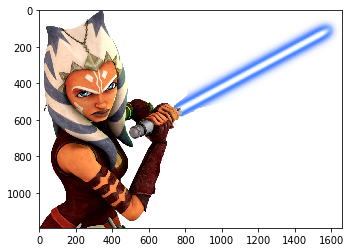

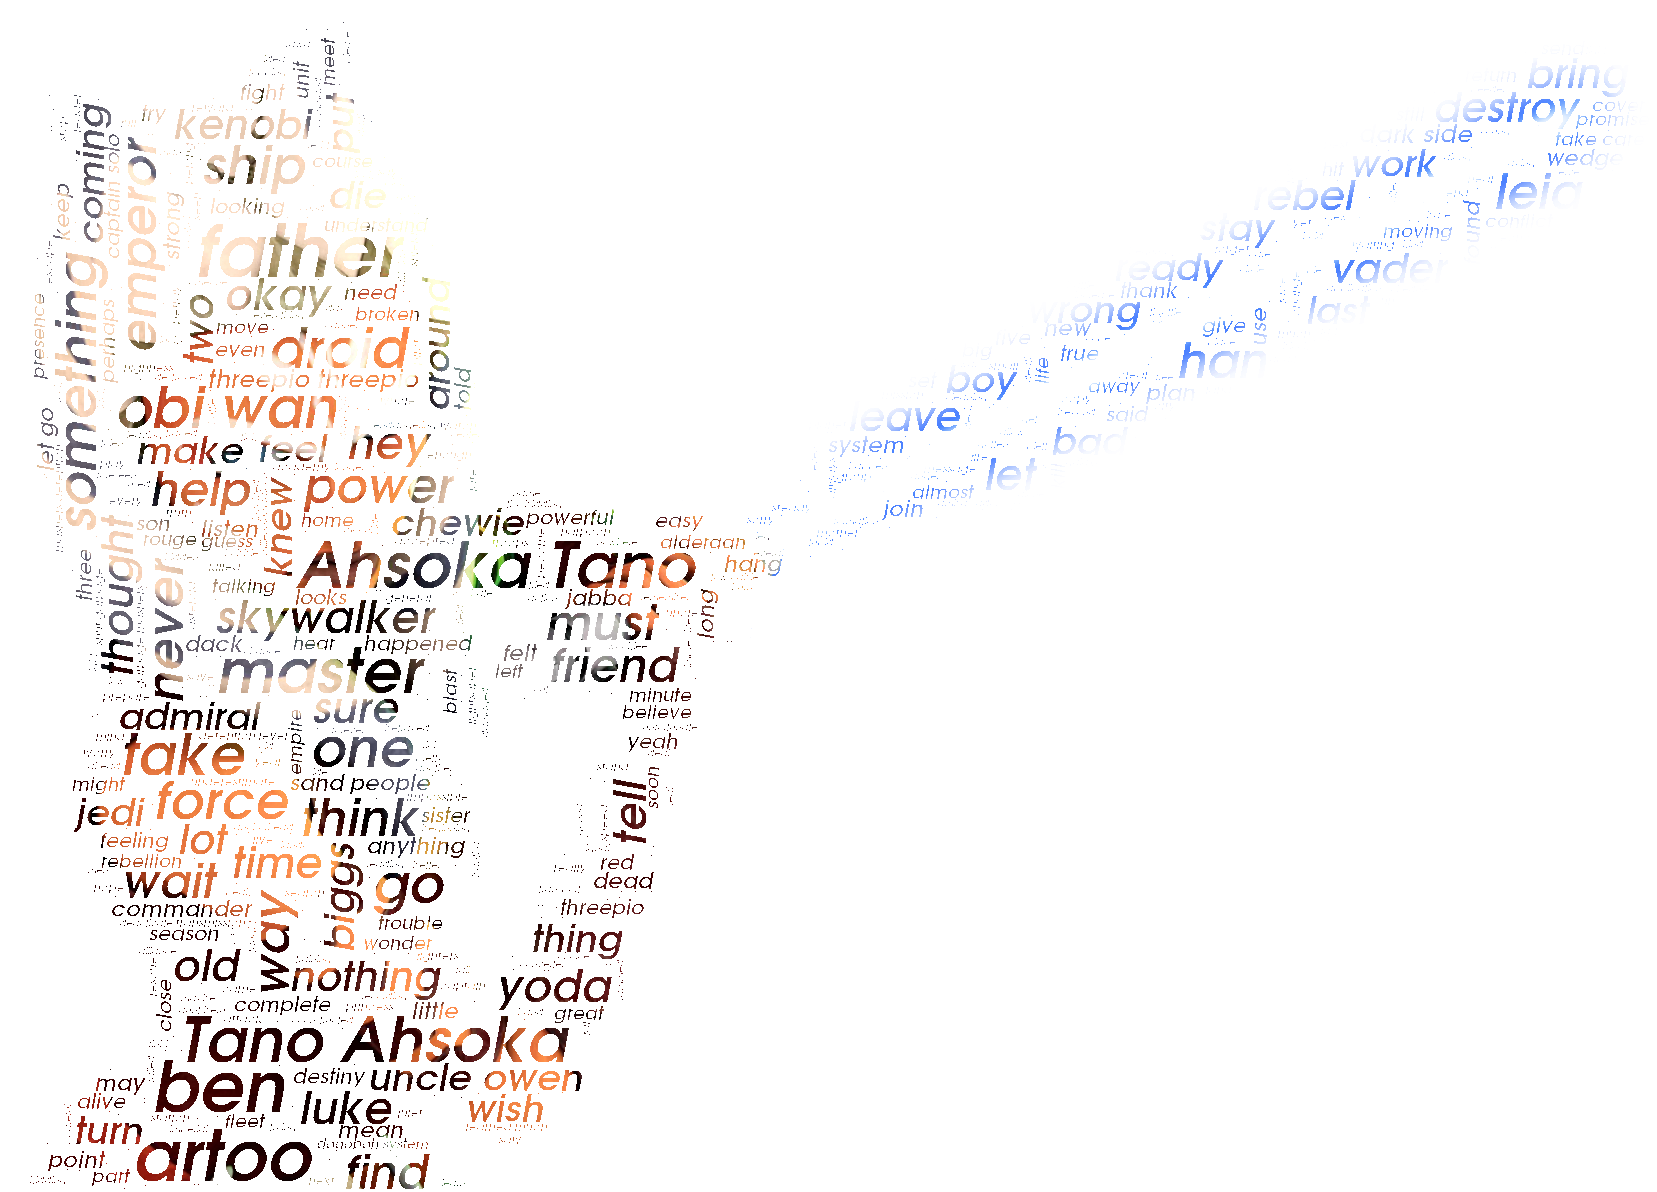

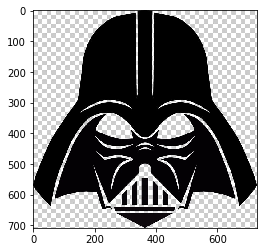

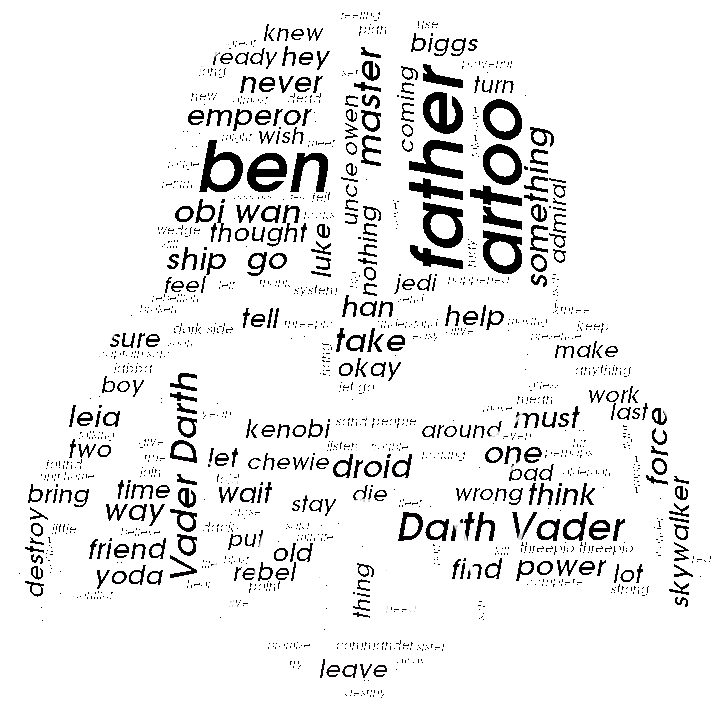

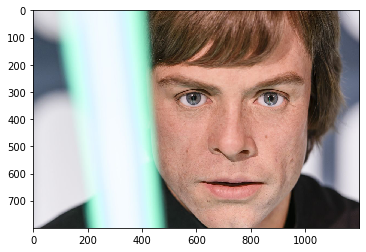

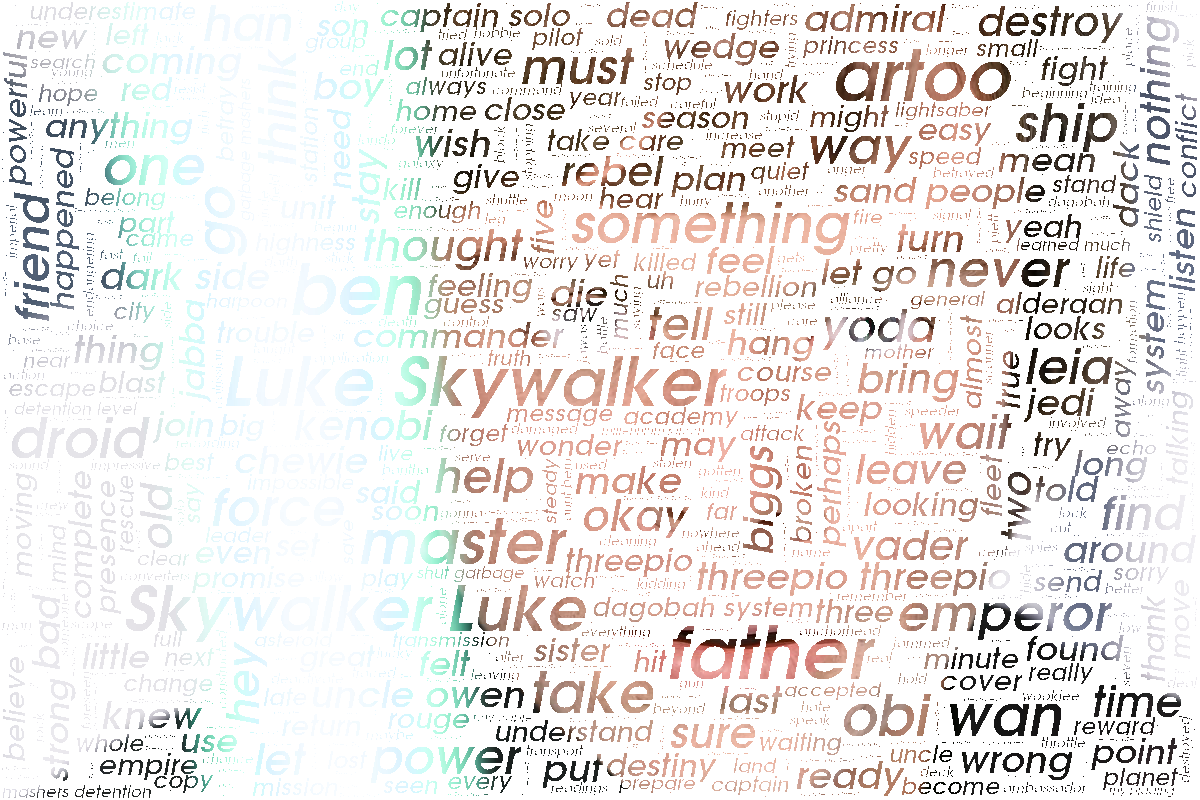

In [9]:
##Original y WordPic
images = ['Ahsoka_Tano.png','Darth_Vader.jpg','Luke_Skywalker.jpg']
for image in images:
    get_wordcloud(texto, liga, image)

## Vectorized

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def vect_img(dir_image,name_image, n = 6):
    #Sub-función para desplegar la imagen
    def plot_data(data):
      plt.imshow(data, interpolation='nearest')
      plt.show()

    #Obtener imagen en RGB
    img = cv2.cvtColor(cv2.imread(dir_image + name_image),cv2.COLOR_BGR2RGB)
    #Guardar dimensión para re-convertir array a imagen
    img_shape = img.shape
    #Mostrar imagen original
    plot_data(img)

    #DF con 3 columnas y el núm de filas necesario (n*m que es la dim de la imagen)
    X = pd.DataFrame(img.reshape((-1,3)))
    #Instanciar Kmeans
    cluster = KMeans(n_clusters = n)
    #Agregar nueva columna al DF, será la predicción de clúster
    X["cl"] = cluster.fit_predict(X)
    #Promedio de los colores por clúster
    cl_data = X.groupby("cl").mean().reset_index()
    #Añadir info al DF
    X = X.merge(cl_data, on ="cl", how ="left")
    #Sobreescribir colores originales por los "n" promedios
    color_cluster = X.loc[:, ["0_y", "1_y", "2_y"]].values
    #Presentar imagen alterada
    vect = Image.fromarray(np.uint8(color_cluster.reshape((img_shape[0],img_shape[1], 3))))
    vect.save(dir_image +f'V_{name_image[:-4]}.png')
    display(vect)

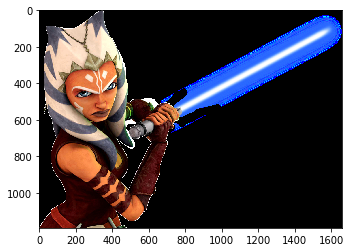

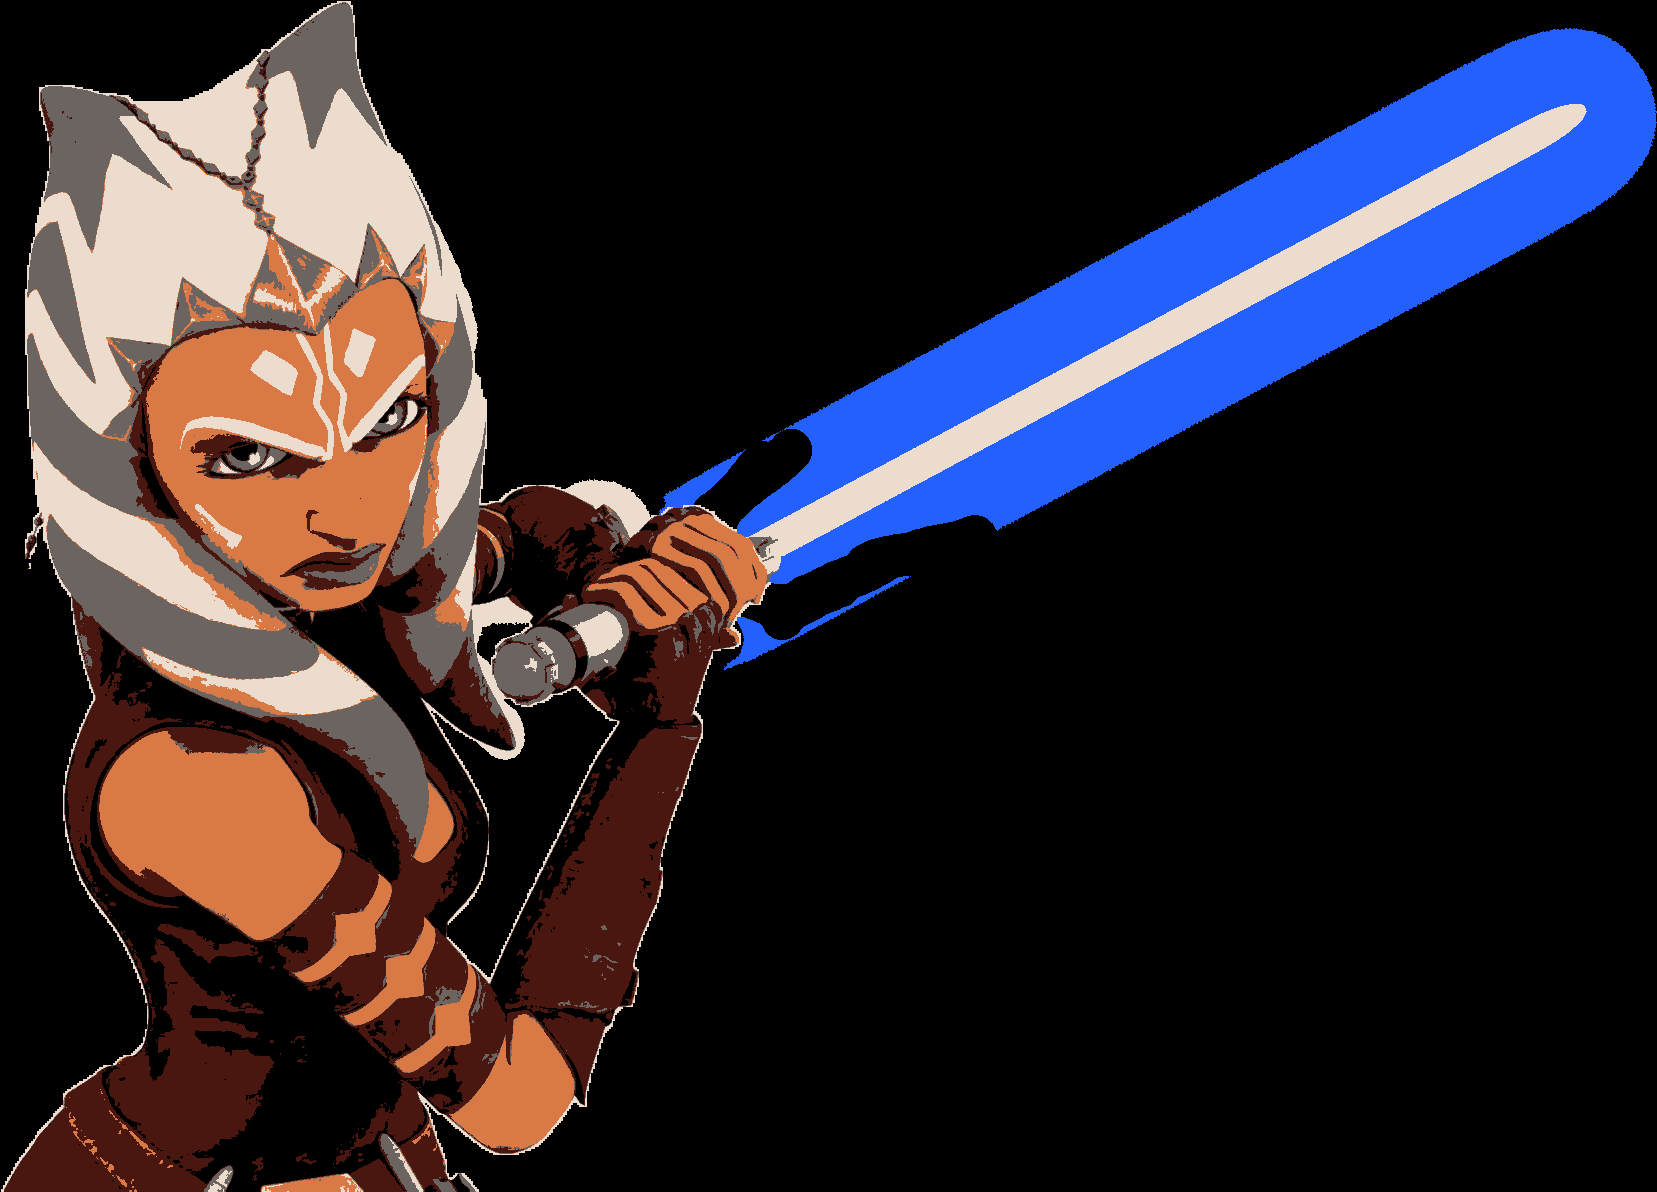

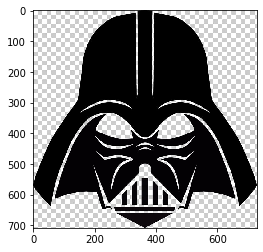

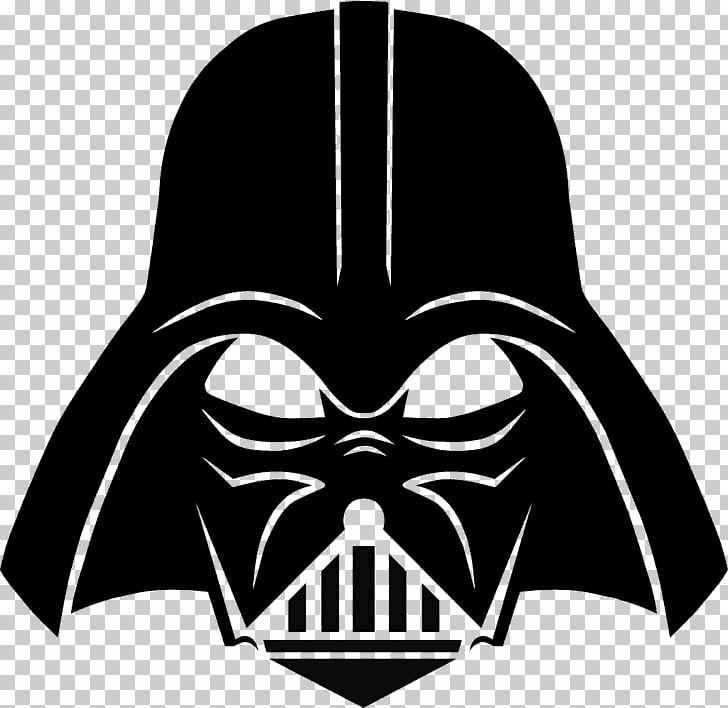

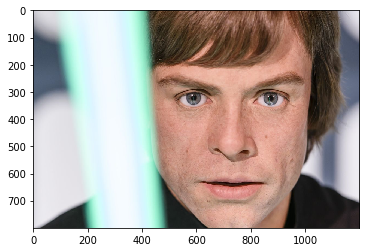

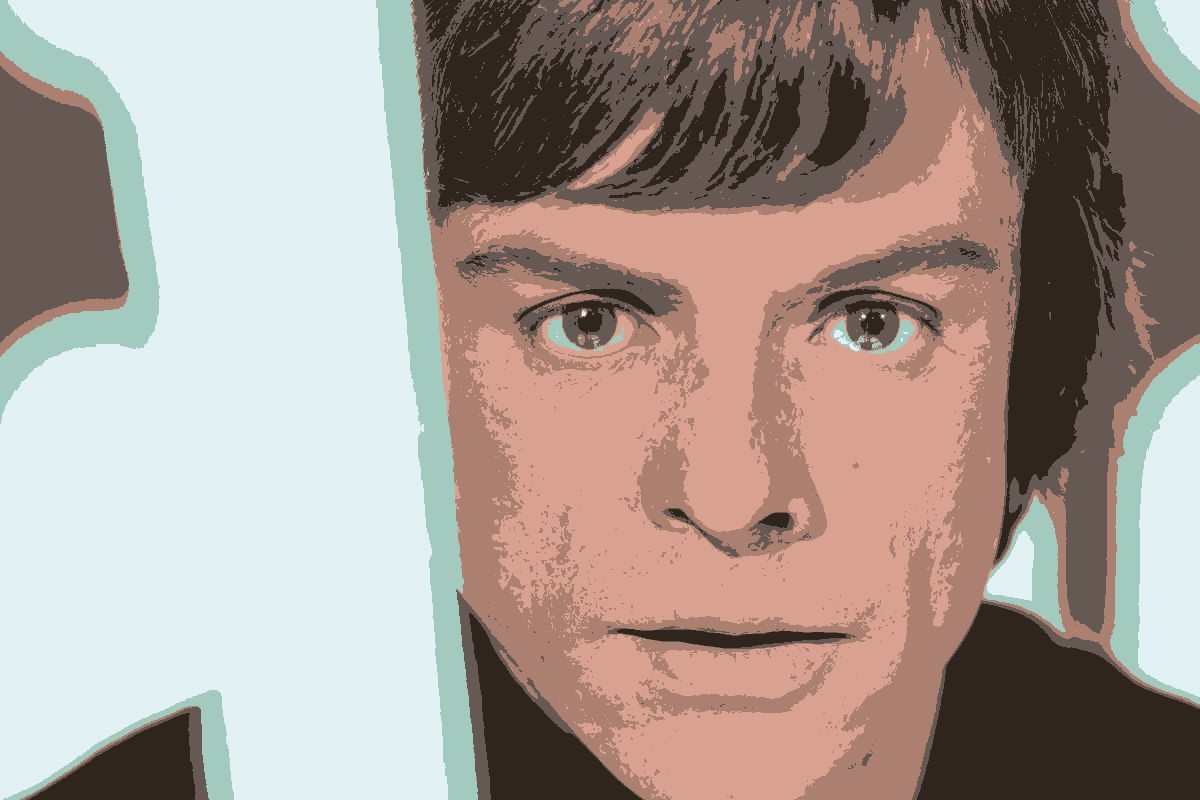

In [13]:
##Original y Vectorized
images = ['Ahsoka_Tano.png','Darth_Vader.jpg','Luke_Skywalker.jpg']
for image in images:
    vect_img(liga,image)

## Lo mejor de dos mundos

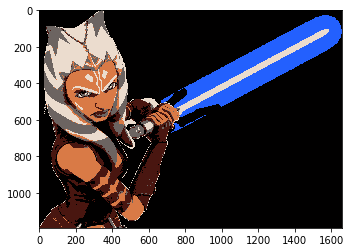

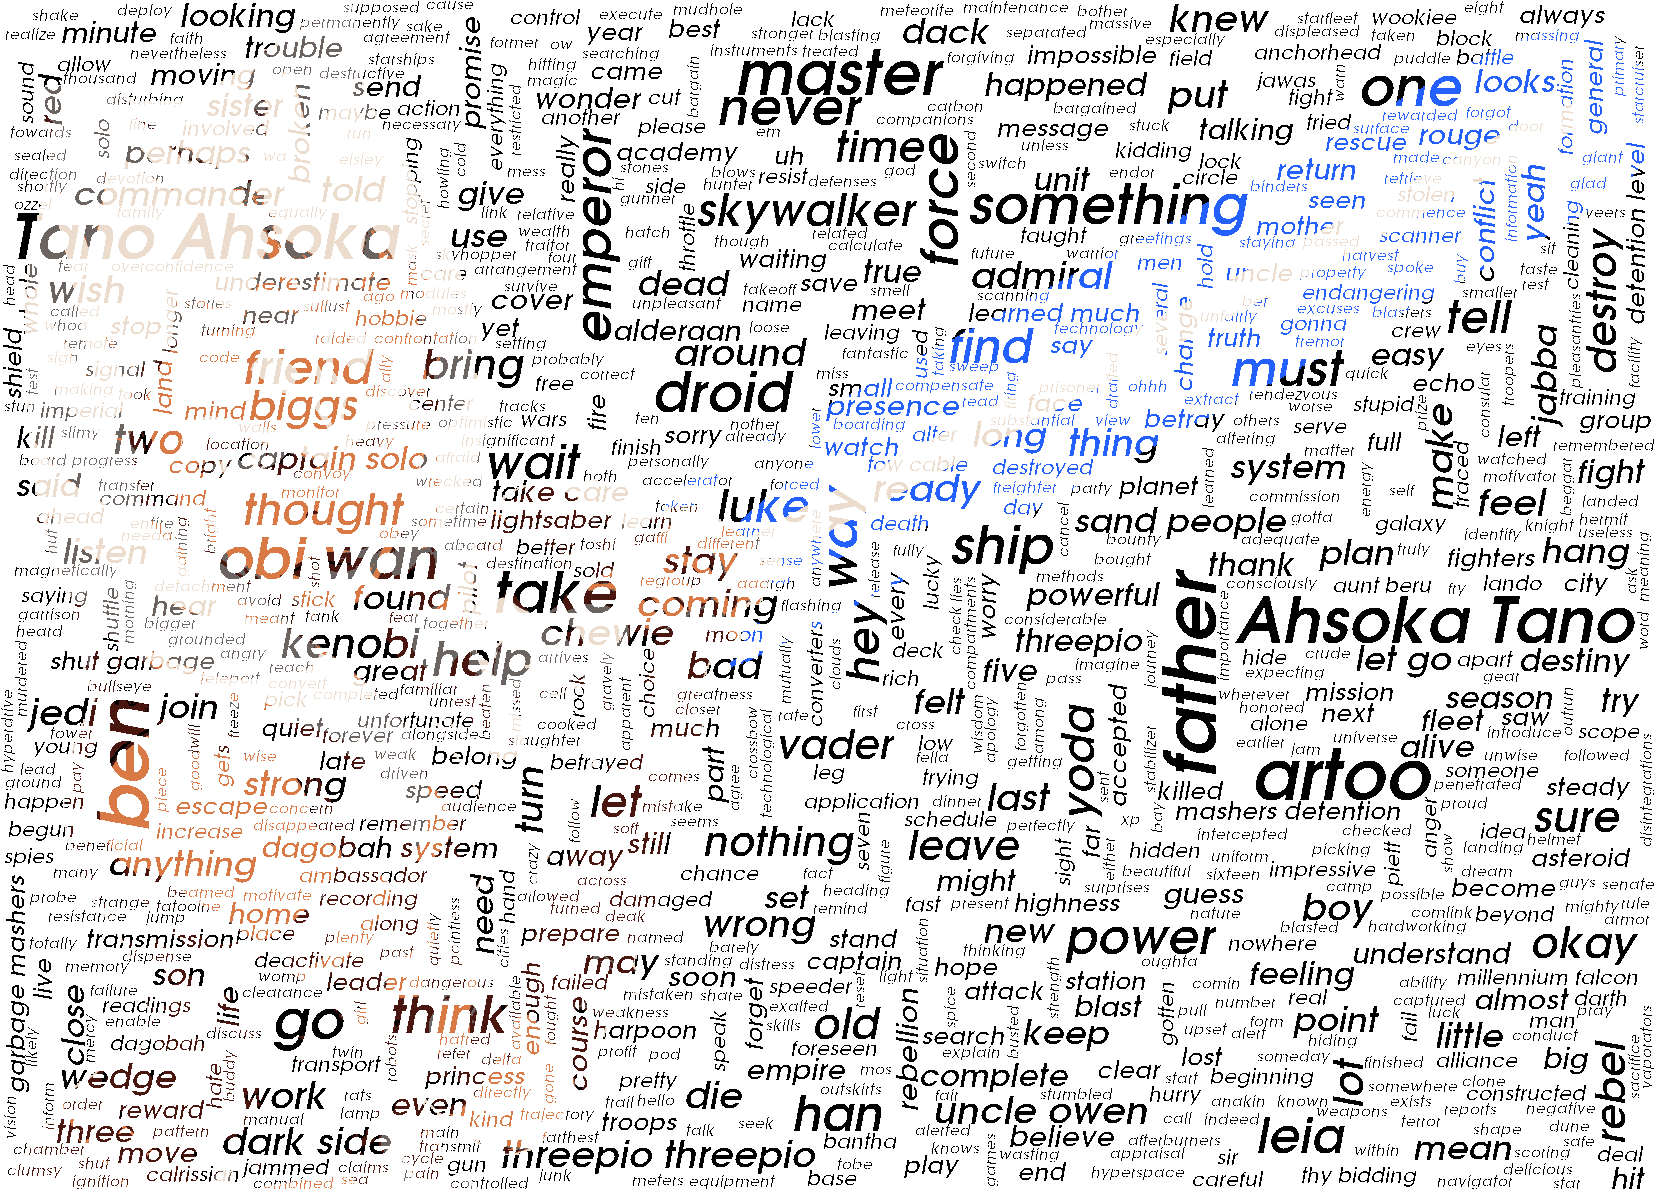

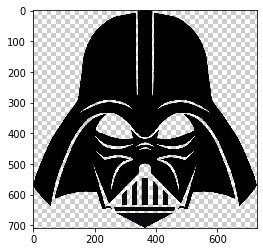

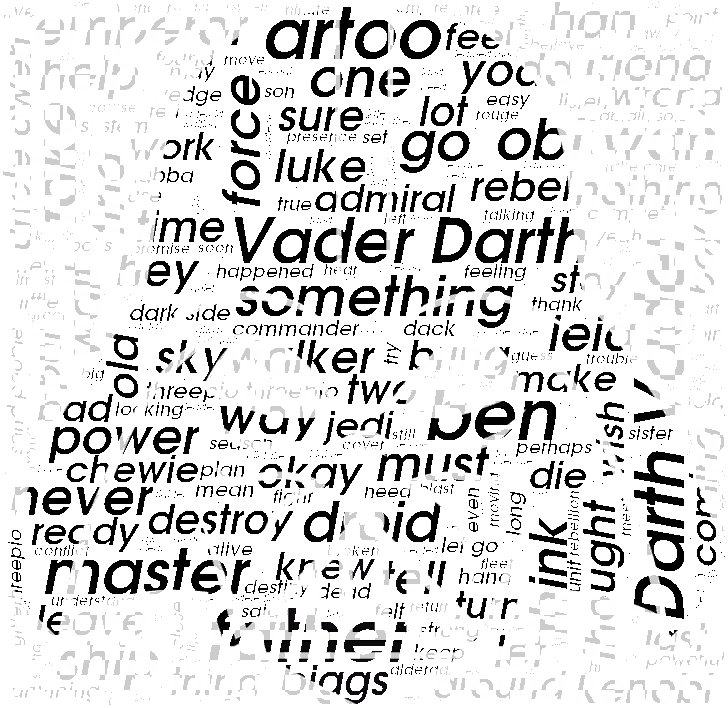

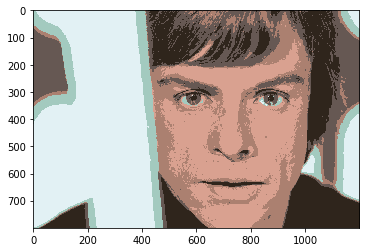

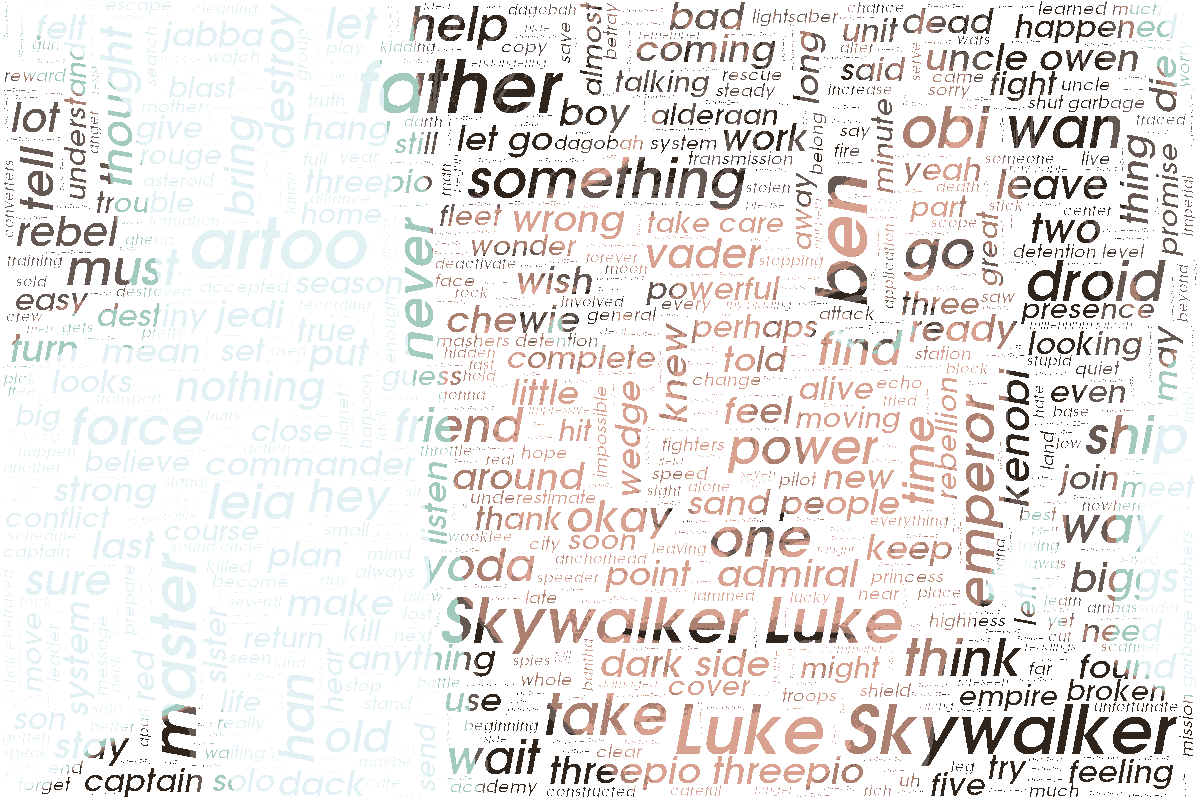

In [15]:
##Original, Vectorized y WordPic
images = ['Ahsoka_Tano.png','Darth_Vader.jpg','Luke_Skywalker.jpg']
for image in images:
    get_wordcloud(texto, liga, f'V_{image[:-4]}.png')